# What are some of the posting patterns on the DS-Connect group ?
![Bokeh][graph]

1. Been rather busy on the new job lately, didnt have much time to mantain this blog.
2. Recently there was a visualisation challenge posted on OnePublicService DataScience group on facebook's workplace
3. Unfortunately a tableau viz beat my entry over the most likes.
4. Nevertheless I thought it would be useful to explain the visualisation and workings.
5. "Keeping It Simple" is always a good principle to follow for any visualisation.

Some observations as follows

- Govtech (Blue) users frequently posts mid-day 12pm-6pm Tues-Tues
- SCDF (Purple) users has bigger posts outside weekdays office hours - PSDm,Mindef,CSC,MoM are after-office-hours only posters
- CPF (Orange) users posts are more frequent in the morning before 8am
- Bigger posts are usually submitted in latter half of the day (afternoon)
- Hardcore Govtech users posting at 1-2am at night
- During Weekend afternoons the group becomes a ghost town

[graph]: https://wykeith.github.io/images/ds-graph.png

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from math import pi

from bokeh.palettes import d3
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    DatetimeTickFormatter,
    NumeralTickFormatter,
    Range1d,
    Label,
    Jitter,
    CategoricalColorMapper
)
output_notebook()


Loading BokehJS ...

In [2]:
# Import the group feed
feed = pd.read_csv('data/feed.csv', encoding = "ISO-8859-1", parse_dates= ['Time'])
feed['Time']=feed['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')

feed.head()

,User ID,Message,Link,Likes,Reactions,Comments,Shares,Time
0,A100014233114571,Some of you might have noticed ... we have cro...,NaN,12,12,3,NaN,2017-11-08 15:42:01+08:00
1,A100014233114571,Since there's some discussions around this ......,NaN,6,6,9,NaN,2017-11-07 09:00:01+08:00
2,A100014831348861,# **RSVP for Test Drive Sessions**\r\n\r\nGovT...,NaN,3,3,3,1.0,2017-11-07 12:17:56+08:00
3,A100013460912741,Even a simple device like a toilet paper holde...,https://onepublicservice.facebook.com/photo.ph...,3,3,1,NaN,2017-11-08 09:34:56+08:00
4,A100015595003931,This article explores 7 ways to fail at data a...,https://www.cio.com/article/3235959/analytics/...,8,8,0,NaN,2017-11-08 07:30:53+08:00


In [3]:
# Import the user data

members = pd.read_csv('data/member.csv', encoding = "ISO-8859-1")
#members['Agency'] = members['Agency'].astype("category")
members.head()

,User ID,Name,Agency
0,A100016211345164,Usha Nanthani,ura.gov.sg
1,A100020784203224,Anne Quah,parl.gov.sg
2,A100021100161528,Lillian Ba,mas.gov.sg
3,A100015589604408,Wah Tin Tan,cpf.gov.sg
4,A100014744505056,May Chen,cpe.gov.sg


In [4]:
# Cross-reference the user ID against User's name and agency

merged = pd.merge(feed, members, on='User ID')
merged.head()

,User ID,Message,Link,Likes,Reactions,Comments,Shares,Time,Name,Agency
0,A100014233114571,Some of you might have noticed ... we have cro...,NaN,12,12,3,NaN,2017-11-08 15:42:01+08:00,Joseph Tan,tech.gov.sg
1,A100014233114571,Since there's some discussions around this ......,NaN,6,6,9,NaN,2017-11-07 09:00:01+08:00,Joseph Tan,tech.gov.sg
2,A100014233114571,http://www.straitstimes.com/singapore/new-law-...,http://www.straitstimes.com/singapore/new-law-...,9,9,1,1.0,2017-11-07 08:55:16+08:00,Joseph Tan,tech.gov.sg
3,A100014233114571,Very interesting viz on global warming by Tabl...,https://onepublicservice.facebook.com/photo.ph...,4,4,1,NaN,2017-11-02 11:00:05+08:00,Joseph Tan,tech.gov.sg
4,A100014233114571,"Tableau Zen Master, Ryan Sleepers framework.",https://onepublicservice.facebook.com/photo.ph...,5,5,1,NaN,2017-11-02 11:26:47+08:00,Joseph Tan,tech.gov.sg


In [5]:
## Clean up the data and aggregate stats
merged['wordcount'] = merged.Message.apply(lambda x: len(str(x).split(' ')))
merged['Interactions'] = merged['Likes'] + merged['Reactions'] + merged['Comments']
merged['Letter_count'] = merged['Message'].str.len()
merged['day_of_week'] = merged['Time'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
merged['day_of_week'] = merged['day_of_week'].apply(lambda x: x+1)
#merged['day_of_week'] = merged['day_of_week'].apply(lambda x: days[x])
merged['hour_of_day'] = merged['Time'].dt.strftime('%H:%M:%S').apply(lambda x: dt.datetime.strptime(x,'%H:%M:%S'))
merged.drop(['Message','Link'],1,inplace=True)
merged.head()

,User ID,Likes,Reactions,Comments,Shares,Time,Name,Agency,wordcount,Interactions,Letter_count,day_of_week,hour_of_day
0,A100014233114571,12,12,3,NaN,2017-11-08 15:42:01+08:00,Joseph Tan,tech.gov.sg,101,27,593.0,3,1900-01-01 15:42:01
1,A100014233114571,6,6,9,NaN,2017-11-07 09:00:01+08:00,Joseph Tan,tech.gov.sg,20,21,136.0,2,1900-01-01 09:00:01
2,A100014233114571,9,9,1,1.0,2017-11-07 08:55:16+08:00,Joseph Tan,tech.gov.sg,1,19,78.0,2,1900-01-01 08:55:16
3,A100014233114571,4,4,1,NaN,2017-11-02 11:00:05+08:00,Joseph Tan,tech.gov.sg,12,9,75.0,4,1900-01-01 11:00:05
4,A100014233114571,5,5,1,NaN,2017-11-02 11:26:47+08:00,Joseph Tan,tech.gov.sg,6,11,45.0,4,1900-01-01 11:26:47


Agency
tech.gov.sg           121
cpf.gov.sg             99
sport.gov.sg           15
pmo.gov.sg             14
scdf.gov.sg             7
pub.gov.sg              6
vital.gov.sg            5
csa.gov.sg              4
rp.edu.sg               3
moe.gov.sg              3
cscollege.gov.sg        2
defence.gov.sg          2
psd.gov.sg              2
sp.edu.sg               2
nea.gov.sg              1
mom.gov.sg              1
tp.edu.sg               1
mha.gov.sg              1
scei.a-star.edu.sg      1
spf.gov.sg              1
spring.gov.sg           1
caas.gov.sg             1
agd.gov.sg              1
Name: Agency, dtype: int64


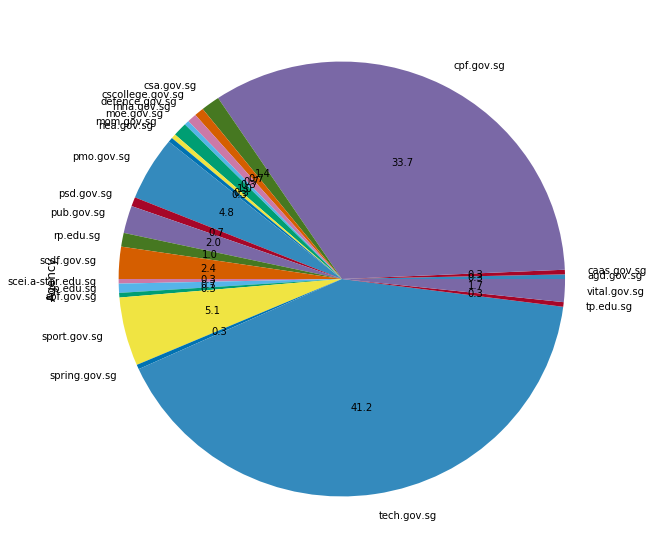

In [6]:
### In descending order post counts shares per agency

posts_merge = merged.groupby(['Agency'], axis=0)['Agency'].count()
print(posts_merge.sort_values(ascending=False))
with plt.style.context(('bmh')):
    posts_merge.plot.pie(autopct='%.1f',figsize=(10, 10))

Agency
tech.gov.sg           760
cpf.gov.sg            231
spf.gov.sg             67
sport.gov.sg           44
csa.gov.sg             42
defence.gov.sg         39
scdf.gov.sg            39
psd.gov.sg             22
pmo.gov.sg             22
vital.gov.sg           21
pub.gov.sg             11
rp.edu.sg              11
moe.gov.sg              9
mha.gov.sg              4
sp.edu.sg               4
scei.a-star.edu.sg      3
agd.gov.sg              3
spring.gov.sg           2
tp.edu.sg               1
cscollege.gov.sg        1
caas.gov.sg             1
nea.gov.sg              0
mom.gov.sg              0
Name: Likes, dtype: int64


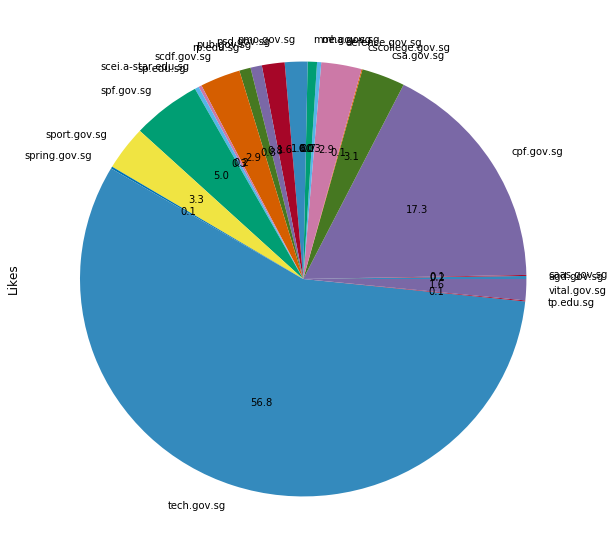

In [7]:
### In descending order total likes share per agency

interactions_merge = (merged.groupby(['Agency'], axis=0)['Likes'].sum())
print(interactions_merge.sort_values(ascending=False))
with plt.style.context(('bmh')):
    interactions_merge.plot.pie(autopct='%.1f',figsize=(10, 10))

In [8]:
def normalize(df,base = 25):
    result = df.copy()
    result = (df - df.mean()) / (df.max() - df.min())*2*base+base
    return result

In [9]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
AGENCY = ['tech.gov.sg', 'cpf.gov.sg', 'sport.gov.sg', 'pmo.gov.sg',
       'scdf.gov.sg', 'pub.gov.sg', 'vital.gov.sg', 'csa.gov.sg', 'rp.edu.sg',
       'moe.gov.sg', 'cscollege.gov.sg', 'defence.gov.sg', 'psd.gov.sg',
       'sp.edu.sg', 'nea.gov.sg', 'mom.gov.sg', 'tp.edu.sg', 'mha.gov.sg',
       'scei.a-star.edu.sg', 'spf.gov.sg', 'spring.gov.sg', 'caas.gov.sg',
       'agd.gov.sg']
    
source = ColumnDataSource(merged)
TOOLS = ["hover,crosshair,save,pan,box_zoom,reset,wheel_zoom"]

p = figure(plot_width=900, plot_height=500, y_range=DAYS, tools=TOOLS, x_axis_type='datetime',
           title="DS Posting Activity - Diameter indicates Normalised Values")

color_mapper = CategoricalColorMapper(factors=AGENCY, palette=d3['Category10'][10])

scattersource = ColumnDataSource(data=dict(
    Name = merged.Name,
    Agency = merged.Agency,
    x = merged.hour_of_day,
    y = merged.day_of_week,
    color = merged.Agency,
    size = normalize(merged.wordcount),
    alpha = [0.7] * merged.shape[0]
))

scatter = p.circle(x={'field': 'x'},
            y={'field': 'y', 'transform': Jitter(distribution='normal',mean=0,width=0.1)},
            size={'field': 'size'},
            line_color="#030303",
            fill_color={'field': 'color', 'transform': color_mapper},
            source=scattersource,
            legend='color',
            alpha={'field': 'alpha'})

p.xaxis[0].formatter.days = ['%Hh']
p.x_range.range_padding = 0
p.ygrid.band_fill_alpha = 0.1
p.ygrid.band_fill_color = "grey"
p.ygrid.grid_line_color = None

p.select_one(HoverTool).tooltips = [
    ("Poster", "@Name"),
    ("Agency", "@Agency"),
    ("Normalised Value", "@size")
]
p.legend.orientation = "horizontal"
p.legend.location = "top_left"

show(p, notebook_handle=True)


def source(Type,Month,Base=25):
    if   Type == "Likes": data,color = normalize(merged.Likes,Base),'purple'
    elif Type == "Reactions": data,color = normalize(merged.Reactions,Base),'green'
    elif Type == "Comments": data,color = normalize(merged.Comments,Base),'blue'
    elif Type == "Shares": data,color = normalize(merged.Shares,Base),'red'
    elif Type == "Wordcount": data,color = normalize(merged.wordcount,Base),'yellow'    
    
    scatter.data_source.data['size'] = data
    scatter.data_source.data['x'] = merged.hour_of_day
    scatter.data_source.data['y'] = merged.day_of_week
    scatter.data_source.data['Agency'] = merged.Agency
    scatter.data_source.data['Name'] = merged.Name
    scatter.data_source.data['color'] = merged.Agency
    
    alpha=[]
    for index, row in merged.iterrows():
        if Month == 13: alpha.append(0.7) ### Show all
        elif row.Time.month == Month: alpha.append(0.8)
        else:  alpha.append(0.1)
    scatter.data_source.data['alpha'] = alpha
    push_notebook()

/opt/conda/lib/python3.6/site-packages/bokeh/models/mappers.py:56: UserWarning: Palette length does not match number of
factors. ['cscollege.gov.sg', 'defence.gov.sg', 'psd.gov.sg', 'sp.edu.sg', 'nea.gov.sg', 'mom.gov.sg', 'tp.edu.sg', 'mha.gov.sg', 'scei.a-star.edu.sg', 'spf.gov.sg', 'spring.gov.sg', 'caas.gov.sg', 'agd.gov.sg'] will be assigned to `nan_color` gray
  factors. %s will be assigned to `nan_color` %s""" % (extra_factors, self.nan_color))


In [10]:
# Some buttons to change the visualised values , you wont be able to see this rendered on the blog.
# Download the jupyter notebook on my github to test

interact(source, Type=["Wordcount", "Likes", "Reactions", "Comments", "Shares"], Month={'All Months':13,'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':11,'Nov':11,'Dec':12}, Base=(5,50))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.source>

In [11]:
# Office Hour Posters Weekdays only
df_officehr = merged[merged.day_of_week <= 5].set_index('hour_of_day').between_time("0800","1800").groupby(['Agency'], axis=0)['Agency'].count()
# After office Posters Weekdays only
df_afterhr = merged[merged.day_of_week <= 5].set_index('hour_of_day').between_time("1800","0800").groupby(['Agency'], axis=0)['Agency'].count()
result_hr = pd.concat([df_officehr, df_afterhr], axis=1,keys=['count_officehr','count_afterhr'])
result_hr.head()

,count_officehr,count_afterhr
agd.gov.sg,1.0,NaN
caas.gov.sg,1.0,NaN
cpf.gov.sg,21.0,59.0
csa.gov.sg,2.0,1.0
cscollege.gov.sg,NaN,1.0


In [12]:
# AM posts
df1 = merged[merged.day_of_week <= 5].set_index('hour_of_day').between_time("0000","1200").groupby(['Agency'], axis=0)['Letter_count'].sum()
# PM posts
df2 = merged[merged.day_of_week <= 5].set_index('hour_of_day').between_time("1200","0000").groupby(['Agency'], axis=0)['Letter_count'].sum()
result_size = pd.concat([-df1, df2], axis=1,keys=['AM_postsize','PM_postsize'])
result_size.head()

,AM_postsize,PM_postsize
agd.gov.sg,-254.0,NaN
caas.gov.sg,NaN,312.0
cpf.gov.sg,-5516.0,5304.0
csa.gov.sg,NaN,676.0
cscollege.gov.sg,NaN,20.0


In [13]:
# For Weekdays only
combined_result = pd.concat([result_hr,result_size], axis=1).fillna(0)
combined_result['pct_off'] = combined_result.count_officehr / (combined_result.count_officehr + combined_result.count_afterhr) * 100
combined_result['pct_aft'] = combined_result.count_afterhr / (combined_result.count_officehr + combined_result.count_afterhr) * 100
combined_result

,count_officehr,count_afterhr,AM_postsize,PM_postsize,pct_off,pct_aft
agd.gov.sg,1.0,0.0,-254.0,0.0,100.000000,0.000000
caas.gov.sg,1.0,0.0,0.0,312.0,100.000000,0.000000
cpf.gov.sg,21.0,59.0,-5516.0,5304.0,26.250000,73.750000
csa.gov.sg,2.0,1.0,0.0,676.0,66.666667,33.333333
cscollege.gov.sg,0.0,1.0,0.0,20.0,0.000000,100.000000
defence.gov.sg,0.0,2.0,-135.0,163.0,0.000000,100.000000
moe.gov.sg,2.0,1.0,0.0,536.0,66.666667,33.333333
mom.gov.sg,0.0,1.0,0.0,131.0,0.000000,100.000000
nea.gov.sg,1.0,0.0,0.0,364.0,100.000000,0.000000
pmo.gov.sg,11.0,3.0,0.0,0.0,78.571429,21.428571


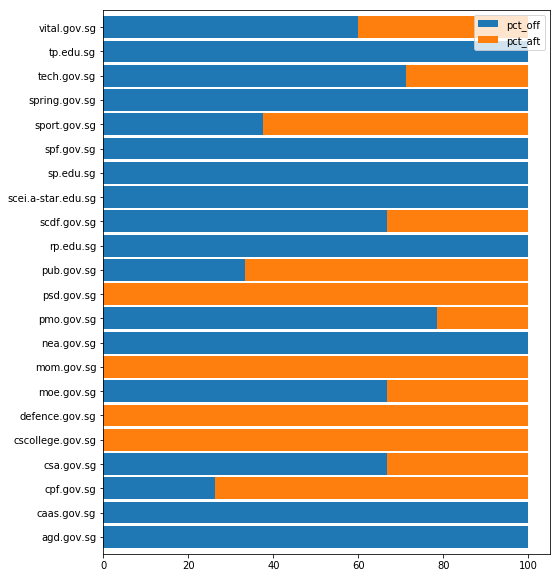

In [14]:
# Plotout percentage office hours posters VS after hours posters
combined_result[['pct_off','pct_aft']].plot.barh(stacked=True,figsize=(8, 10), width=0.9)

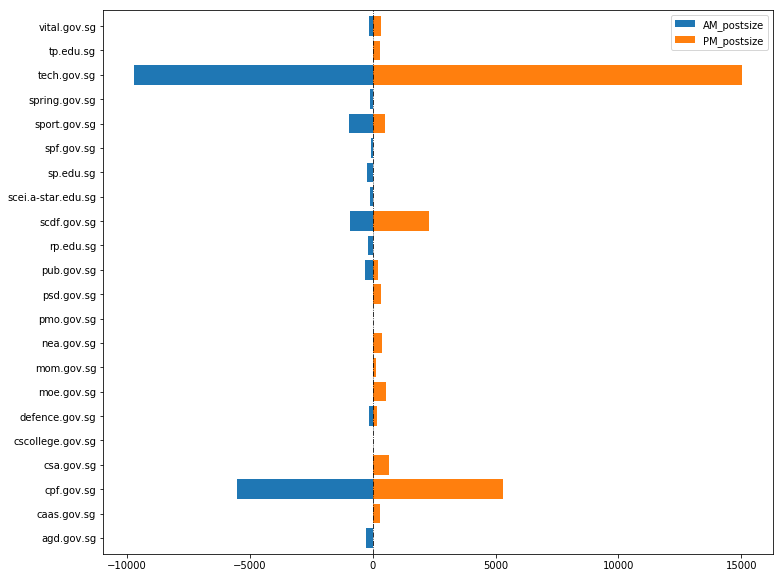

In [15]:
#Post sizes in morning VS Post sizes in afternoon , weekdays only
combined_result[['AM_postsize','PM_postsize']].plot.barh(stacked=True,figsize=(12,10), width=0.8)
plt.axvline(0, color='k', ls='dashdot', lw=0.8)